Adding all necessary packages

In [98]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
#import tensorflow
import tensorflow as tf

from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives


from keras.layers import Input, Lambda, Dense, Flatten


from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

from keras.models import Sequential

from glob import glob


Make sure you have your kaggle.json in ~/.kaggle folder

In [2]:
# Downloading the data to the Google Colab

import zipfile
import os
import kaggle


# Set up Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = "alirezaakramianarani"
os.environ['KAGGLE_KEY'] = "e829e44b33725933200785423bc93888"
download_path = 'D:/centennialcollege/winter2024/comp58'
# Downloading the data
kaggle.api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path=download_path, unzip=True)




Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


Fix the distribution of the validation set. Currently there are only 16 images in the validation set. We will combine everything and then split it again.

In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import shutil
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/tmp/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

dataset_path= '/tmp/chest_xray/'
new_dataset_path = '/tmp/chest_xray_new/'
if not os.path.exists(new_dataset_path):
   for split in ['train', 'val', 'test']:
       for cls in ['NORMAL', 'PNEUMONIA']:
           os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

   for cls in ['NORMAL', 'PNEUMONIA']:
       all_files = []
       for split in ['train', 'val', 'test']:
           source_folder = f'{dataset_path}/{split}/{cls}'
           files = os.listdir(source_folder)
           all_files.extend([(file, source_folder) for file in files])

       random.shuffle(all_files)

       train_files = all_files[:int(len(all_files)*0.8)]
       val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
       test_files = all_files[int(len(all_files)*0.9):]

       for file, source_folder in train_files:
           dest = f'{new_dataset_path}/train/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in val_files:
           dest = f'{new_dataset_path}/val/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest)

       for file, source_folder in test_files:
           dest = f'{new_dataset_path}/test/{cls}/{file}'
           shutil.copy(f'{source_folder}/{file}', dest) 

/tmp/chest_xray/chest_xray\.DS_Store
/tmp/chest_xray/chest_xray\test\.DS_Store
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0001-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0003-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0005-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0006-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0007-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0009-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0010-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0011-0001-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0011-0001-0002.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0011-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0013-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0015-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0016-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0017-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0019-0001.jpeg
/tmp/chest_xray/chest_xray\test\NORMAL\IM-0021-0001.jpeg

Splitting the data into train, validation and test sets

In [100]:
# Defining the paths of the directories that were unzipped
train_dir = '/tmp/chest_xray_new/train'
val_dir = '/tmp/chest_xray_new/val'
test_dir = '/tmp/chest_xray_new/test'

In [101]:
#Define image sizes
img_height = 128
img_width = 128
batch_size = 32


In [102]:
#import images into dataframes
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    color_mode = 'rgb',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    color_mode = 'rgb',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    color_mode = 'rgb',
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 4684 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Found 587 files belonging to 2 classes.


In [103]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)
val_labels_onehot = to_categorical(val_labels)




In [104]:
train_labels


array([[[[[[[[0., 1.],
             [1., 0.]],

            [[1., 0.],
             [0., 1.]]],


           [[[1., 0.],
             [0., 1.]],

            [[0., 1.],
             [1., 0.]]]],



          [[[[1., 0.],
             [0., 1.]],

            [[0., 1.],
             [1., 0.]]],


           [[[0., 1.],
             [1., 0.]],

            [[1., 0.],
             [0., 1.]]]]],




         [[[[[1., 0.],
             [0., 1.]],

            [[0., 1.],
             [1., 0.]]],


           [[[0., 1.],
             [1., 0.]],

            [[1., 0.],
             [0., 1.]]]],



          [[[[0., 1.],
             [1., 0.]],

            [[1., 0.],
             [0., 1.]]],


           [[[1., 0.],
             [0., 1.]],

            [[0., 1.],
             [1., 0.]]]]]],





        [[[[[[1., 0.],
             [0., 1.]],

            [[0., 1.],
             [1., 0.]]],


           [[[0., 1.],
             [1., 0.]],

            [[1., 0.],
             [0., 1.]]]],



    

In [105]:
print("Count values of instances per label in train dataset\n")
print(pd.DataFrame(np.unique(train_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))
print("\n\nCount values of instances per label in test dataset\n")
print(pd.DataFrame(np.unique(test_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))
print("\n\nCount values of instances per label in validation dataset\n")
print(pd.DataFrame(np.unique(val_labels, return_counts = True), index=['Label', 'count'], columns=['Normal','Pneumonia']))

Count values of instances per label in train dataset

         Normal  Pneumonia
Label       0.0        1.0
count  299776.0   299776.0


Count values of instances per label in test dataset

       Normal  Pneumonia
Label     0.0        1.0
count   587.0      587.0


Count values of instances per label in validation dataset

       Normal  Pneumonia
Label     0.0        1.0
count  9360.0     9360.0


Image visualization

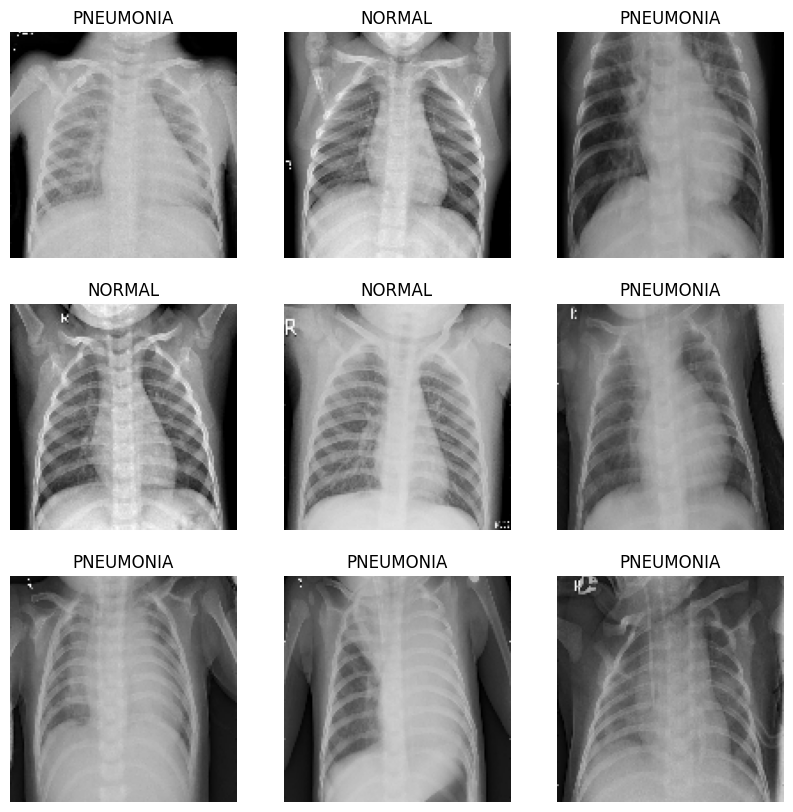

In [106]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
        plt.title(train_df.class_names[labels[i]])
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_df = train_df.cache().prefetch(buffer_size=AUTOTUNE)
val_df = val_df.cache().prefetch(buffer_size=AUTOTUNE)
test_df = test_df.cache().prefetch(buffer_size=AUTOTUNE)

Keras model

In [107]:
input_layer = Input(shape=(img_height,img_width, 3))

In [108]:
from keras.models import Sequential
from keras.layers import Rescaling, RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, RandomBrightness

# Add data augmentation layers
data_augmentation = Sequential([
  Rescaling(1./255),  # Rescale the images
  RandomCrop(height=img_height, width=img_width),  # Randomly crop the images
  RandomFlip("horizontal_and_vertical"),  # Apply horizontal and vertical flip
])


In [109]:
# Apply the data augmentation to the input
augmented_input = data_augmentation(input_layer)

In [110]:
inceptionV3=InceptionV3(input_tensor=augmented_input, # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet' )

In [111]:
# don't train existing weights
for layer in inceptionV3.layers:
    layer.trainable = False

In [112]:
# our layers - 
flattened_output = Flatten()(inceptionV3.output)

In [113]:
prediction = Dense(2, activation='softmax')(flattened_output)

In [114]:
print(data_augmentation.summary())



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_crop_3 (RandomCrop)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [115]:
model = Model(inputs=input_layer, outputs=prediction)

In [116]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 128, 128,  │          0 │ input_layer_6[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 63, 63,    │        864 │ sequential_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 61, 61,    │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 61, 61,    │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 30, 30,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 30, 30,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 28, 28,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_286[0][0]

 Total params: 21,819,170 (83.23 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [118]:

r = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Epoch 1/2


ValueError: Layer 'functional_17' expected 1 input(s). Received 2 instead.

Model Validation

NameError: name 'history' is not defined

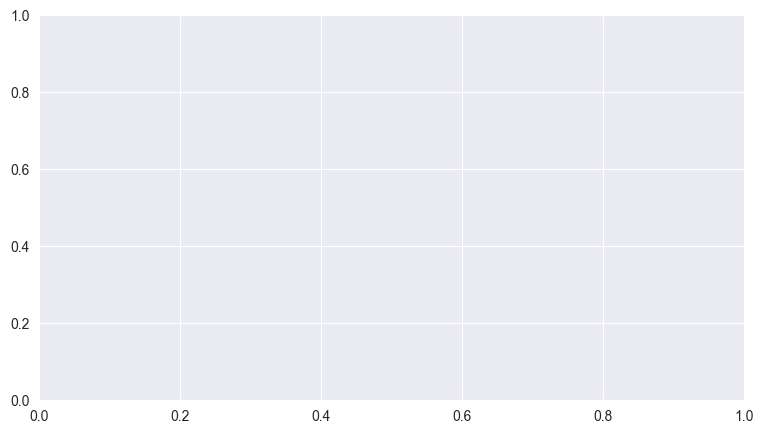

In [12]:
plt.figure(figsize=(20,5))

# ploting accuracy and validation accuracy
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='grey', label='Train Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

# plotting loss and validation loss (sparse categorical crossentropy)
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='grey', label='Train Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='red', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

plt.show()

In [ ]:
model.evaluate(test_df)